In [198]:
# imports
import torch
import torch.nn as nn
import numpy as np

# direct access to torch.nn functions (without using classes)
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# 7.56 Using a *class* instead of **nn.sequential** to create a model
#### This project uses the code from 7.47 ANN classification, but a custom class has been used to create the model. The rest of the code is the same.
- **pros**: more flexibility, customizable to needs 
- **cons**: more difficult or complex to set up, not as beginner friendly

### Creating the dataset
- This is the same as the ANN qwerties classification dataset.

In [199]:
# creating dataset
def create_data_cloud(num_per_cluster, blur_value):
    # center of data cloud
    A = [1,1]
    B = [5,1]

    # generating data points
    a = [A[0]+np.random.randn(num_per_cluster)*blur_value, A[1]+np.random.randn(num_per_cluster)*blur_value]
    b = [B[0]+np.random.randn(num_per_cluster)*blur_value, B[1]+np.random.randn(num_per_cluster)*blur_value]

    # category labels (dummy or 'hot' encoding)
    labels_np = np.vstack((np.zeros((num_per_cluster,1)), np.ones((num_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

    # concatenate data into matrix
    data_np = np.hstack((a,b)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).float()

    return data, labels

# Creating the ANN model Class

In [200]:
class custom_ANN_model(nn.Module):
    def __init__(self):
        super(custom_ANN_model, self).__init__()
        
        # input layer
        self.input_layer = nn.Linear(2, 1)

        # output layer
        self.output_layer = nn.Linear(1, 1)

    def forward(self, x):
        # pass data through input layer
        x = self.input_layer(x)
        
        # applying ReLU activation function
        hidden_layer = F.relu(x)

        # output layer
        x = self.output_layer(hidden_layer)
        output_layer = torch.sigmoid(x)

        return output_layer

## Model Training Function

In [201]:
# training model
def ANN_classification_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # parameters
    losses = torch.zeros(epochs)
    per_epoch_accuracy = []
    
    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)
        
        # calculating loss
        loss = loss_function(y_hat, input_labels)
        losses[epoch_IDX] = loss
        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

        # calculating accuracy at each epoch
        matches = torch.argmax(y_hat, axis=1) == input_labels # converting to booleans (T / F)
        matches_num = matches.float()                         # convert bools to ints (0 / 1)
        accuracy_percent = 100*torch.mean(matches_num)        # average of correct matches
        per_epoch_accuracy.append(accuracy_percent)

    # final forward pass
    final_predictions = model(input_data)

    # overall accuracy
    predicted_lables = torch.argmax(final_predictions, axis=1)
    total_accuracy = 100*torch.mean((predicted_lables==input_labels).float())

    return final_predictions, losses, per_epoch_accuracy, total_accuracy, y_hat



## Model Parameters

In [202]:
# creating dataset
num_per_cluster = 100
blur_value = 0.5

test_data, test_labels = create_data_cloud(num_per_cluster, blur_value)

# creating model
ANN_model = custom_ANN_model()

# model params
set_learning_rate = 0.01
set_loss_func = nn.BCEWithLogitsLoss()
set_optimizer = torch.optim.SGD(ANN_model.parameters(), lr=set_learning_rate)

# training model
final_predictions, losses, per_epoch_accuracy, model_accuracy, y_hat = ANN_classification_training(
    model= ANN_model,
    loss_function= set_loss_func,
    m_optimizer= set_optimizer,
    input_data= test_data,
    input_labels= test_labels,
    epochs= 1000
)

# manually calculating losses
predicted_labels = final_predictions > 0.5 # True (1) if in category b. False (0) if in category a.

# finding errors
misclassified = np.where(predicted_labels != test_labels)[0] # checking for dataset a, which should be categorized as 0.
calculated_accuracy = 100-100*len(misclassified)/(2*num_per_cluster)

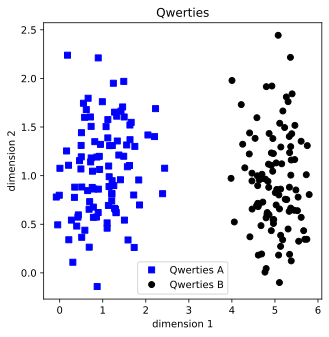

Final accuracy: 90%


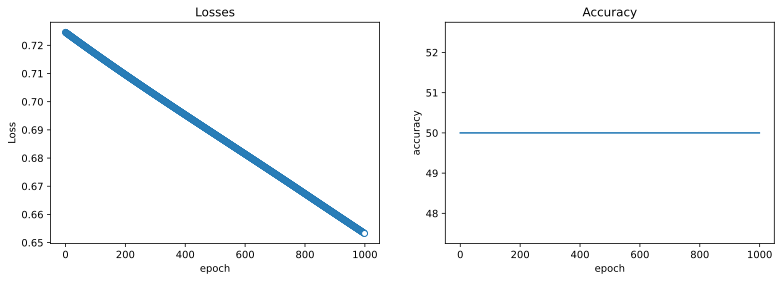

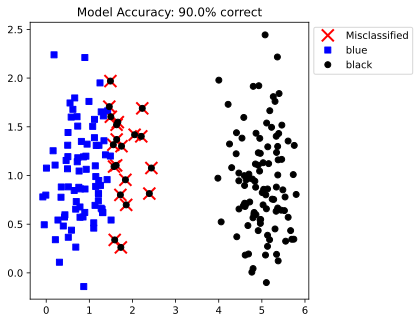

In [203]:
# plotting data
fig = plt.figure(figsize=(5,5))

plt.plot(test_data[np.where(test_labels==0)[0],0], test_data[np.where(test_labels==0)[0],1], 'bs')
plt.plot(test_data[np.where(test_labels==1)[0],0], test_data[np.where(test_labels==1)[0],1], 'ko')
plt.plot(test_data[np.where(test_labels==2)[0],0], test_data[np.where(test_labels==2)[0],1], '^')

plt.title('Qwerties')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.legend(('Qwerties A', 'Qwerties B'))

plt.show()

# plotting final results
print('Final accuracy: %g%%'%calculated_accuracy)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
ax[0].set_title('Losses')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(per_epoch_accuracy)
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

plt.show()

# plotting accuracy
fig = plt.figure(figsize=(5,5))
plt.plot(test_data[misclassified,0], test_data[misclassified,1], 'rx', markersize=12, markeredgewidth=2)
plt.plot(test_data[np.where(~predicted_labels)[0],0], test_data[np.where(~predicted_labels)[0],1], 'bs')
plt.plot(test_data[np.where(predicted_labels)[0],0], test_data[np.where(predicted_labels)[0], 1], 'ko')

plt.legend(['Misclassified', 'blue', 'black'], bbox_to_anchor=(1,1))
plt.title(f'Model Accuracy: {calculated_accuracy}% correct')

plt.show()